# 6. Comparison: Accuracy and Request Processing Time

compare to [GraphPipe User Guide: Performance](https://oracle.github.io/graphpipe/#/guide/user-guide/performance)

In [35]:
import time

import matplotlib.pyplot as plt
import numpy as np

from emnist_dl2prod.utils import eval_serving_performance, eval_throughput

In [36]:
# ip = '255.255.255.255'
ip = 'localhost'

In [37]:
flask_url = 'http://{}:5000/'.format(ip)
graphpipe_url = 'http://{}:9000'.format(ip)
tf_serving_docker_url = 'http://{}:8501/v1/models/tf_emnist:predict'.format(ip)

* **Start Flask Webservice**

```
emnist-webservice
```

```
python emnist_webserver.py
```

* **Start GraphPipe Docker Container**

```
docker run -it --rm \
      -v "$(pwd)/../models:/models/" \
      -p 9000:9000 \
      sleepsonthefloor/graphpipe-tf:cpu \
      --model=/models/dnn_model_tf.pb \
      --listen=0.0.0.0:9000
```


* **Start TF Serving Docker Container**

```
docker run -p 8501:8501 \
--name emnist_model --mount type=bind,source=$(pwd)/../models/tf_emnist,target=/models/tf_emnist \
-e MODEL_NAME=tf_emnist -t tensorflow/serving:1.10.1 &
```

## Single Instance Evaluation

In [38]:
flask_durations = eval_serving_performance(n_examples=1000, n_print_examples=0,
                                           request_url=flask_url, dataset='test')

[2018-10-18 15:14:11] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
Accuracy on 1000 test images: 77.60%


In [39]:
tf_serving_docker_durations = eval_serving_performance(n_examples=1000, n_print_examples=0,
                                                       request_url=tf_serving_docker_url, dataset='test')

[2018-10-18 15:14:29] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
Accuracy on 1000 test images: 77.60%


In [40]:
graphpipe_docker_durations = eval_serving_performance(n_examples=1000, n_print_examples=0,
                                                      request_url=graphpipe_url, dataset='test',
                                                      use_graphpipe=True)

[2018-10-18 15:14:45] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
Accuracy on 1000 test images: 77.60%


In [41]:
print("Flask Mean: {} ms".format(np.mean(flask_durations)))
print("Flask Std: {} ms".format(np.std(flask_durations)))

Flask Mean: 7.9973730000000005 ms
Flask Std: 12.973738313372555 ms


In [42]:
print("TF Serving Docker Mean: {} ms".format(np.mean(tf_serving_docker_durations)))
print("TF Serving Docker Std: {} ms".format(np.std(tf_serving_docker_durations)))

TF Serving Docker Mean: 5.18772 ms
TF Serving Docker Std: 2.520463681071402 ms


In [43]:
print("GraphPipe Docker Mean: {} ms".format(np.mean(graphpipe_docker_durations)))
print("GraphPipe Docker Std: {} ms".format(np.std(graphpipe_docker_durations)))

GraphPipe Docker Mean: 8.344878000000001 ms
GraphPipe Docker Std: 5.084058122318823 ms


## Data Visualizations

### Boxplots

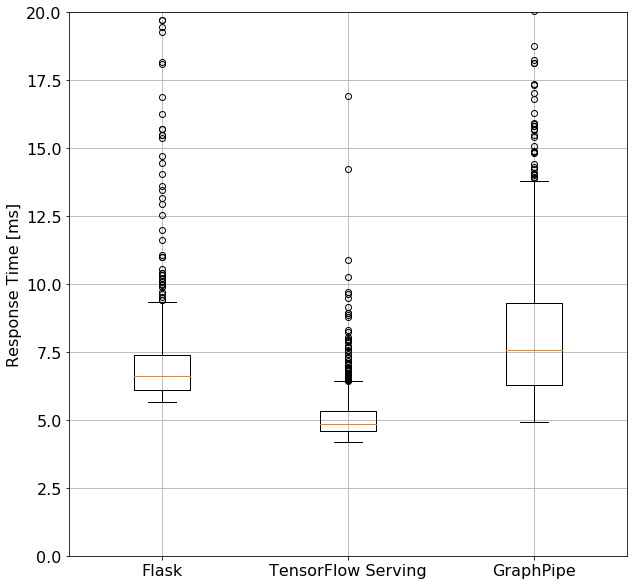

In [47]:
plt.figure(figsize=(10,10))
plt.boxplot([flask_durations,
             tf_serving_docker_durations,
             graphpipe_docker_durations],
            labels=['Flask', 'TensorFlow Serving', 'GraphPipe'])
plt.ylabel("Response Time [ms]", fontsize=16)
plt.ylim(0, 20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True)
plt.show()

### Distribution

In [45]:
x = np.linspace(0, 1, 101)
flask_quantiles = []
graphpipe_quantiles = []
tf_quantiles = []
for q in x:
    flask_quantiles.append(np.quantile(flask_durations, q=q))
    graphpipe_quantiles.append(np.quantile(graphpipe_docker_durations, q=q))
    tf_quantiles.append(np.quantile(tf_serving_docker_durations, q=q))

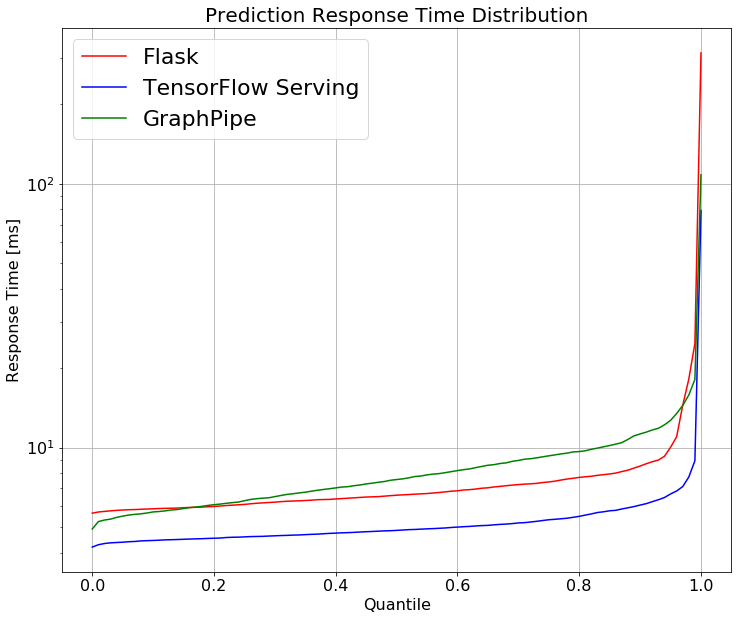

In [46]:
plt.figure(figsize=(12,10))
plt.semilogy(x, flask_quantiles, c='r', label='Flask')
plt.semilogy(x, tf_quantiles, c='b', label='TensorFlow Serving')
plt.semilogy(x, graphpipe_quantiles, c='g', label='GraphPipe')
plt.title("Prediction Response Time Distribution", fontsize=20)
plt.xlabel("Quantile", fontsize=16)
plt.ylabel("Response Time [ms]", fontsize=16)
plt.legend(fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.grid(True)
plt.show()

## Thoughput Measurement using batch-wise Inference

Following [Oracle's Graphpipe Release Post](https://blogs.oracle.com/developers/introducing-graphpipe) we use `batch_size=128` to measure throughput as per *requests/second*.

Note: As ONNX currently doesn't allow to export variable batch-sizes, we need to exchange a model for each batch size. For this part, we change from `batch_size=1` to `batch_size=128` in order to stick with the batch size Oracle mentioned to use for their evaluation. If you like to run the same, you just have to change the first dimension for our example input prior to the PyTorch ONNX export.

`batch_size=1`

In [48]:
batch_size = 1
results = {}
results['flask'] = eval_throughput(duration=60, request_url=flask_url, batch_size=batch_size)
time.sleep(5)
results['tf_serving'] = eval_throughput(duration=60, request_url=tf_serving_docker_url, batch_size=batch_size)
time.sleep(5)
results['graphpipe'] = eval_throughput(duration=60, request_url=graphpipe_url,
                                       batch_size=batch_size, use_graphpipe=True)

[2018-10-18 15:15:56] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
[2018-10-18 15:15:59] INFO:emnist_dl2prod.utils:Throughput Evaluation on URL http://localhost:5000/ for 60 seconds ...
[2018-10-18 15:16:59] INFO:emnist_dl2prod.utils:Throughput Summary:
URL: http://localhost:5000/
Duration: 60 [s]
Total Requests: 7500
Requests/Second: 125.00
[2018-10-18 15:17:12] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
[2018-10-18 15:17:16] INFO:emnist_dl2prod.utils:Throughput Evaluation on URL http://localhost:8501/v1/models/tf_emnist:predict for 60 seconds ...
[2018-10-18 15:18:16] INFO:emnist_dl2prod.utils:Throughput Summary:
URL: http://localhost:8501/v1/models/tf_emnist:predict
Duration: 60 [s]
Total Requests: 12463
Requests/Second: 207.72
[2018-10-18 15:18:29] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
[2018-10-18 15:18:33] INFO:emnist_dl2prod.utils:Through

In [49]:
results

{'flask': (7500, 125.0),
 'tf_serving': (12463, 207.71666666666667),
 'graphpipe': (8836, 147.26666666666668)}

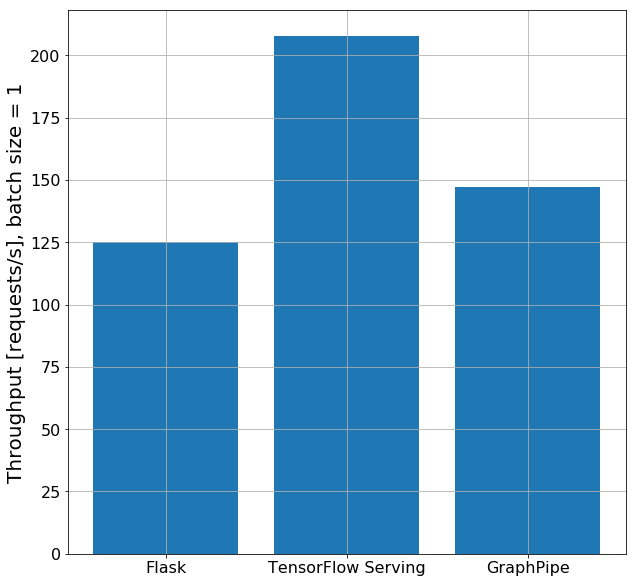

In [50]:
plt.figure(figsize=(10,10))
plt.bar(['Flask', 'TensorFlow Serving', 'GraphPipe'],
        [results['flask'][1], results['tf_serving'][1], results['graphpipe'][1]])
plt.ylabel('Throughput [requests/s], batch size = {}'.format(batch_size), fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.ylim(0,25)
plt.grid(True)
plt.show()

`batch_size=128`

Measure throughput of each Webservice for 60 seconds

In [52]:
batch_size = 128
results = {}
results['flask'] = eval_throughput(duration=60, request_url=flask_url,
                                   dataset='train', batch_size=batch_size)
time.sleep(5)
results['tf_serving'] = eval_throughput(duration=60, request_url=tf_serving_docker_url,
                                        dataset='train', batch_size=batch_size)
time.sleep(5)
results['graphpipe'] = eval_throughput(duration=60, request_url=graphpipe_url,
                                       dataset='train', batch_size=batch_size, use_graphpipe=True)

[2018-10-18 15:25:38] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
[2018-10-18 15:25:51] INFO:emnist_dl2prod.utils:Throughput Evaluation on URL http://localhost:5000/ for 60 seconds ...
[2018-10-18 15:26:51] INFO:emnist_dl2prod.utils:Throughput Summary:
URL: http://localhost:5000/
Duration: 60 [s]
Total Requests: 82304
Requests/Second: 1371.73
[2018-10-18 15:27:04] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
[2018-10-18 15:27:17] INFO:emnist_dl2prod.utils:Throughput Evaluation on URL http://localhost:8501/v1/models/tf_emnist:predict for 60 seconds ...
[2018-10-18 15:28:17] INFO:emnist_dl2prod.utils:Throughput Summary:
URL: http://localhost:8501/v1/models/tf_emnist:predict
Duration: 60 [s]
Total Requests: 129536
Requests/Second: 2158.93
[2018-10-18 15:28:31] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat
[2018-10-18 15:28:39] INFO:emnist_dl2prod.utils:Thr

In [53]:
results

{'flask': (82304, 1371.7333333333333),
 'tf_serving': (129536, 2158.9333333333334),
 'graphpipe': (367616, 6126.933333333333)}

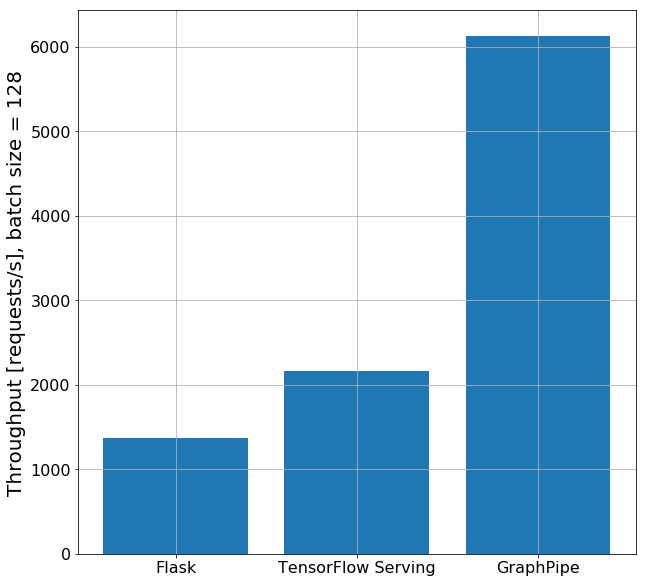

In [54]:
plt.figure(figsize=(10,10))
plt.bar(['Flask', 'TensorFlow Serving', 'GraphPipe'],
        [results['flask'][1], results['tf_serving'][1], results['graphpipe'][1]])
plt.ylabel('Throughput [requests/s], batch size = {}'.format(batch_size), fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.ylim(0,25)
plt.grid(True)
plt.show()